""" Rabi oscillations in two-level atom
    Preston Huft, April 2019
    
    Density matrix approach, neglecting 2nd order AC stark shift
    See: 
        - Mark's notes, eq. 10.30: Optical Block eqs w/ RWA approx. 
        - Metcalf, eq. 2.21
        
    TODO: 
        - get odeintz to take an argument 'params' which is a list
        of parameters to be passed to derivs. WHY IS THIS SO HARD???
"""

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import complex_ode,odeint
import sympy
from sympy import MatrixSymbol,MatAdd,MatMul,Identity,I,Matrix,symbols
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
import time
from sys import getsizeof

In [3]:
###############################################################################
## METHODS and GLOBAL PARAMETERS
###############################################################################

# def odeintz(func, z0, t,params,**kwargs):
def odeintz(func, z0, t,**kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

#     def realfunc(x, t, params):
#         z = x.view(np.complex128)
#         dzdt = func(z, t, params)
#         # func might return a python list, so convert its return
#         # value to an array with type np.complex128, and then return
#         # a np.float64 view of that array.
#         return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    stopwatch = time.time() # time the computation 
    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)
    stopwatch = time.time() - stopwatch

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict#, stopwatch
    else:
        z = result.view(np.complex128)
        return z,stopwatch

def cc(z): 
    return np.conj(z)

## "GLOBAL" VARIABLES (scope excludes method bodies)

dt = 0.05 # the timestep for numerical solutions
threedB = (1-1/np.e) # "3dB" down, or ~ 63 % of an initial amplitude

In [4]:
def derivs(y0,t,t1,t2,D,O):
# def derivs(t,y0,params):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    rgg,ree,reg = y0
#     O,D,t1,t2 = params # Rabi freq,detuning,lifetime,coherence
    
    # time derivatives of density op elements
    curl = 1j/2*(O*cc(reg)-cc(O)*reg) 
    drgg = ree/t1 - curl 
    dree = -ree/t1 + curl
    dreg = (1j*D-1/(2*t1))*reg+1j*O/2*(rgg-ree) # = cc(drge)
    
    return np.array([drgg,dree,dreg])

computation time = 0.018945 [s]


C:\Users\gothr\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


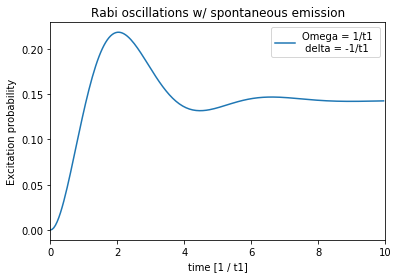

In [5]:
###############################################################################
## Rabi oscillations with spontaneous emission, a slow Rabi frequency, and 
## detuning = -(excited state lifetime) 
## (See Metcalf, pg. 24,Fig. 2.1)
###############################################################################

# initial conditions - system starts in ground state
rho_ee = 0 + 0j
rho_gg = 1 + 0j
rho_eg = 0 + 0j # no initial mixing; this is actually rho^tilda_ge
y0 = np.array([rho_gg,rho_ee,rho_eg]) # bundle i.c.

# equation parameters
t1 = 1 # upper state lifetime (1/gamma)
t2 = np.inf # atomic coherence 
D = -1/t1 # the detuning; run for various values! 
Omega = 1/t1 #1/t1 # treat as real. d*E*exp(-1j*theta) # complex rabi frequency
# params = (Omega,D,t1,t2)# bundle parameters as tuple

t_exp = 10*t1 # experiment duration
t = np.arange(t_exp,step=dt)

# soln = odeintz(derivs, y0, t, params)
soln,comp_time = odeintz(derivs, y0, t, args=(t1,t2,D,Omega))
print("computation time = %f [s]" % comp_time)

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_ylim((0,1))
ax.set_xlim((0,t_exp))
ax.set_title('Rabi oscillations w/ spontaneous emission')
ax.set_xlabel('time [1 / t1]')
ax.set_ylabel('Excitation probability')
ax.plot(t,soln[:,1],label="Omega = 1/t1 \n delta = -1/t1") # plot rho_ee
ax.legend(loc='upper right')
plt.show()

No handles with labels found to put in legend.


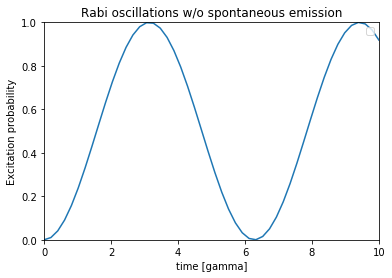

In [21]:
###############################################################################
## Rabi oscillations with no spontaneous emission, for various values
## of detuning from the transition resonance
###############################################################################

# initial conditions - system starts in ground state
rho_ee = 0 + 0j
rho_gg = 1 + 0j
rho_eg = 0 + 0j # no initial mixing; this is actually rho^tilda_ge
y0 = np.array([rho_gg,rho_ee,rho_eg]) # bundle i.c.

# equation parameters
t1 = np.inf # upper state lifetime (1/gamma)
t2 = np.inf # atomic coherence 
D_arr = np.arange(0,4,step=1) # the detuning; run for various values! 
Omega = 1 #1/t1 # treat as real. d*E*exp(-1j*theta) # complex rabi frequency
#params = np.array([Omega,D,t1,t2]) # bundle parameters

# TODO: for param in params: if type(param) = list, iterate over the param
t_exp = 10 # experiment duration
t = np.arange(t_exp,step=dt)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((0,1))
ax.set_xlim((0,t_exp))
ax.set_title('Rabi oscillations w/o spontaneous emission')
ax.set_xlabel('time [gamma]')
ax.set_ylabel('Excitation probability')

# comp_time = 0
# for D in D_arr: # solve and plot for each detuning value
#     soln,ctime = odeintz(derivs, y0, t, args=(t1,t2,D,Omega))
#     ax.plot(t,soln[:,1],label="Detuning = %s "%D) # plot rho_ee
#     comp_time += ctime
# print("computation time = %f [s]" % comp_time)

## Try with solve_ivp
# D = 0 
# func = lambda y,t: derivs(t,y,t1,t2,D,Omega)
# from scipy.integrate import solve_ivp
# t = np.linspace(0,t_exp,50)
# soln = solve_ivp(func,[0,t_exp],y0,t_eval=t)
# ax.plot(soln.t,soln.y[1])

ax.legend(loc='upper right')
plt.show()

c:\program files (x86)\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


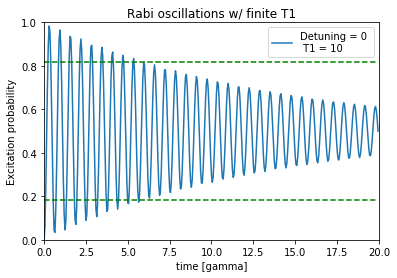

In [41]:
###############################################################################
## Rabi oscillations with a finite lifetime (e.g. some spontaneous emission),
## no detuning
###############################################################################

# initial conditions - system starts in ground state
rho_ee = 0 + 0j
rho_gg = 1 + 0j
rho_eg = 0 + 0j # no initial mixing; this is actually rho^tilda_ge
y0 = np.array([rho_gg,rho_ee,rho_eg]) # bundle i.c.

# equation parameters
t1 = 10 # upper state lifetime (1/gamma)
t2 = np.inf # atomic coherence 
D_arr = np.array([0]) # the detuning; run for various values! 
Omega = 10 #1/t1 # treat as real. d*E*exp(-1j*theta) # complex rabi frequency
#params = np.array([Omega,D,t1,t2]) # bundle parameters

# TODO: for param in params: if type(param) = list, iterate over the param

t_exp = 2*t1 # experiment time in units lifetime
t = np.arange(t_exp,step=dt)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((0,1))
ax.set_xlim((0,t_exp))
ax.set_title('Rabi oscillations w/ finite T1')
ax.set_xlabel('time [gamma]')
ax.set_ylabel('Excitation probability')

for D in D_arr: # solve and plot for each detuning value
    soln,comp_time = odeintz(derivs, y0, t, args=(t1,t2,D,Omega))
    ax.plot(t,soln[:,1],label="Detuning = %s \n T1 = %s" % (D,t1)) # plot rho_ee

# show the 3dB drop off in amplitude. <-- might not be useful here... t1 is 
# evidently not the 1/e time for rabi oscillations. 
ax.plot(t,.5*threedB*np.ones(len(t))+.5,linestyle='--',color='g')
ax.plot(t,.5*(1-threedB)*np.ones(len(t)),linestyle='--',color='g')

ax.legend(loc='upper right')
plt.show()

c:\program files (x86)\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


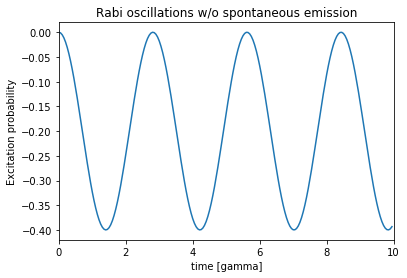

In [159]:
###############################################################################
## ***** SYMBOLIC SYSTEM SOLVER PROTOTYPE *****
## Hamiltonian is wrong but the proof of concept works
## Rabi oscillations with no spontaneous emission, for various values
## of detuning from the transition resonance
###############################################################################

### EVERYTHING IN HERE IS TEST CODE THAT IS INTENDED TO REPRODUCE THE HARD-
### CODED VON NEUMANN EQS FROM A SYMBOLIC HAMILTONIAN; 

def comm(A,B):
    """[A,B]=A.B-B.A. Assumes symbolic matrix."""
    return (MatMul(A,B)-MatMul(B,A)) #.as_mutable

# define symbolic matrices which can be made numeric later
E1,E2,d,O,t = symbols('E1 E2 d O t') # symbolic variables

# Set the parameters of H; arbitrary for now
O = 1; E2 = 1; E1 = 0; d = 1;

H_a = Matrix([[E1,0],[0,E2]])
H_field = Matrix([[-d,cc(O)/2],[O/2,0]])
H = H_a + H_field # the full Hamiltonian
r = MatrixSymbol('r',2,2).as_mutable() # density op
r[0,1]=cc(r[1,0]) # now we need only solve 3 eqs
RHS = 1j*comm(r,H) # RHS of von Neumann eq system
# rhs = np.array([x for x in  RHS]) # the rhs expressions of the von Neumann eqs
rhs = [x for x in  RHS]

# initial conditions - system starts in ground state
r0 = [1+0j,0+0j,0+0j,0+0j] # flattened initial dens. op.

# generate this derivs function from symbolic Hamiltonian and Lambdify
# TODO: include parameters for H as a tuple
derivs = lambdify((flatten([flatten(x) for x in RHS.free_symbols]),t),rhs)
            
t_exp = 10 # experiment duration
ts = np.arange(t_exp,step=dt)

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_ylim((0,1))
ax.set_xlim((0,t_exp))
ax.set_title('Rabi oscillations w/o spontaneous emission')
ax.set_xlabel('time [gamma]')
ax.set_ylabel('Excitation probability')

# this doesn't throw any errors
soln,ctime = odeintz(derivs, r0, ts) #, args=(t1,t2,D,Omega))
ax.plot(ts,soln[:,1]) # plot rho_ee
plt.show()
# comp_time = 0
# for D in D_arr: # solve and plot for each detuning value
#     soln,ctime = odeintz(derivs, y0, t, args=(t1,t2,D,Omega))
#     ax.plot(t,soln[:,1],label="Detuning = %s "%D) # plot rho_ee
#     comp_time += ctime
# print("computation time = %f [s]" % comp_time)

# ax.legend(loc='upper right')
# plt.show()

c:\program files (x86)\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


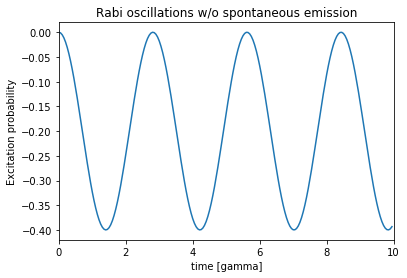

In [159]:
###############################################################################
## ***** SYMBOLIC SYSTEM SOLVER PROTOTYPE *****
## Hamiltonian is wrong but the proof of concept works
## Rabi oscillations with no spontaneous emission, for various values
## of detuning from the transition resonance
###############################################################################

# # initial conditions - system starts in ground state
# rho_ee = 0 + 0j
# rho_gg = 1 + 0j
# rho_eg = 0 + 0j # no initial mixing; this is actually rho^tilda_ge
# y0 = np.array([rho_gg,rho_ee,rho_eg]) # bundle i.c.

### EVERYTHING IN HERE IS TEST CODE THAT IS INTENDED TO REPRODUCE THE HARD-
### CODED VON NEUMANN EQS FROM A SYMBOLIC HAMILTONIAN

def comm(A,B):
    """[A,B]=A.B-B.A. Assumes symbolic matrix."""
    return (MatMul(A,B)-MatMul(B,A)) #.as_mutable

# define symbolic matrices which can be made numeric later
E1,E2,d,O,t = symbols('E1 E2 d O t') # symbolic variables

# Set the parameters of H; arbitrary for now
O = 1; E2 = 1; E1 = 0; d = 1;

H_a = Matrix([[E1,0],[0,E2]])
H_field = Matrix([[-d,cc(O)/2],[O/2,0]])
H = H_a + H_field # the full Hamiltonian
r = MatrixSymbol('r',2,2).as_mutable() # density op
r[0,1]=cc(r[1,0]) # now we need only solve 3 eqs
RHS = 1j*comm(r,H) # RHS of von Neumann eq system
# rhs = np.array([x for x in  RHS]) # the rhs expressions of the von Neumann eqs
rhs = [x for x in  RHS]

# initial conditions - system starts in ground state
r0 = [1+0j,0+0j,0+0j,0+0j] # flattened initial dens. op.

# generate this derivs function from symbolic Hamiltonian and Lambdify
# TODO: include parameters for H as a tuple
derivs = lambdify((flatten([flatten(x) for x in RHS.free_symbols]),t),rhs)
            
t_exp = 10 # experiment duration
ts = np.arange(t_exp,step=dt)

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_ylim((0,1))
ax.set_xlim((0,t_exp))
ax.set_title('Rabi oscillations w/o spontaneous emission')
ax.set_xlabel('time [gamma]')
ax.set_ylabel('Excitation probability')

# this doesn't throw any errors
soln,ctime = odeintz(derivs, r0, ts) #, args=(t1,t2,D,Omega))
ax.plot(ts,soln[:,1]) # plot rho_ee
plt.show()
# comp_time = 0
# for D in D_arr: # solve and plot for each detuning value
#     soln,ctime = odeintz(derivs, y0, t, args=(t1,t2,D,Omega))
#     ax.plot(t,soln[:,1],label="Detuning = %s "%D) # plot rho_ee
#     comp_time += ctime
# print("computation time = %f [s]" % comp_time)

# ax.legend(loc='upper right')
# plt.show()

ValueError: too many values to unpack (expected 3)

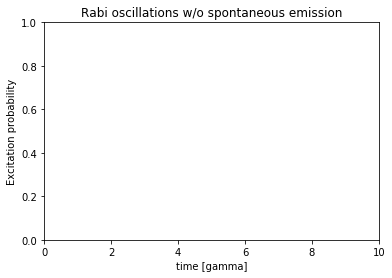

In [157]:
###############################################################################
## ***** SYMBOLIC SYSTEM SOLVER PROTOTYPE, v2 *****
## Rabi oscillations with no spontaneous emission, for various values
## of detuning from the transition resonance
###############################################################################

# # initial conditions - system starts in ground state
# rho_ee = 0 + 0j
# rho_gg = 1 + 0j
# rho_eg = 0 + 0j # no initial mixing; this is actually rho^tilda_ge
# y0 = np.array([rho_gg,rho_ee,rho_eg]) # bundle i.c.

### EVERYTHING IN HERE IS TEST CODE THAT IS INTENDED TO REPRODUCE THE HARD-
### CODED VON NEUMANN EQS FROM A SYMBOLIC HAMILTONIAN

# use a lamda function for the derivs, just as a test; removed decay terms
# this works just fine
# derivs = lambda y0,t,t1,t2,D,O: np.array([- 1j/2*(O*cc(y0[2])-cc(O)*y0[2]),\
#                                           + 1j/2*(O*cc(y0[2])-cc(O)*y0[2]),\
#                                           1j*D*y0[2]+1j*O/2*(y0[0]-y0[1])])

def comm(A,B):
    """[A,B]=A.B-B.A. Assumes symbolic matrix."""
    return (MatMul(A,B)-MatMul(B,A)) #.as_mutable

# define symbolic matrices which can be made numeric later
E1,E2,d,O,t = symbols('E1 E2 d O t') # symbolic variables

# Set the parameters of H; arbitrary for now
O = 1; E2 = 1; E1 = 0; d = 1;

H_a = Matrix([[E1,0],[0,E2]])
H_field = Matrix([[-d,cc(O)/2],[O/2,0]])
H = H_a + H_field # the full Hamiltonian
r = MatrixSymbol('r',2,2).as_mutable() # density op
r[0,1]=cc(r[1,0]) # now we need only solve 3 eqs
RHS = 1j*comm(r,H) # RHS of von Neumann eq system
# rhs = np.array([x for x in  RHS]) # the rhs expressions of the von Neumann eqs
rhs = [x for x in  RHS]
args = flatten([flatten(x) for x in RHS.free_symbols]) # args for derivs func

# initial conditions - system starts in ground state
r0 = [1+0j,0+0j,0+0j,0+0j] # flattened initial dens. op.

# remove redundant elements from matrices/lists
del rhs[3]
del args[3]

# generate this derivs function from symbolic Hamiltonian and Lambdify
# derivs = lambdify((np.array(flatten([flatten(x) for x in RHS.free_symbols])),t),rhs)
# derivs = lambdify((flatten([flatten(x) for x in RHS.free_symbols]),t),rhs)
derivs = lambdify((args,t),rhs)
            
# TODO: for param in params: if type(param) = list, iterate over the param
t_exp = 10 # experiment duration
ts = np.arange(t_exp,step=dt)

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_ylim((0,1))
ax.set_xlim((0,t_exp))
ax.set_title('Rabi oscillations w/o spontaneous emission')
ax.set_xlabel('time [gamma]')
ax.set_ylabel('Excitation probability')

# this doesn't throw any errors
soln,ctime = odeintz(derivs, r0, ts) #, args=(t1,t2,D,Omega))
ax.plot(ts,soln[:,1]) # plot rho_ee
plt.show()
# comp_time = 0
# for D in D_arr: # solve and plot for each detuning value
#     soln,ctime = odeintz(derivs, y0, t, args=(t1,t2,D,Omega))
#     ax.plot(t,soln[:,1],label="Detuning = %s "%D) # plot rho_ee
#     comp_time += ctime
# print("computation time = %f [s]" % comp_time)

# ax.legend(loc='upper right')
# plt.show()

In [161]:
x = np.linspace(1,9,21)

In [162]:
len(x)

21